In [2]:
import os 
os.chdir('../')
print(os.getcwd())
import utils
from spyridonidis.Ford_dataset_s import SatGrdDatasetFordPresentation, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from spyridonidis.models_ford_s import ModelFord
from spyridonidis.utils_s import render_point_cloud
# from models_ford import ModelFord as ModelFord_orig
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt 
import matplotlib.gridspec as gridspec
import numpy as np 
from VGG import Unet, space2channel

from spyridonidis.train_ford_3DOF_s import parse_args

args = parse_args()
save_path ='ModelsFord/3DoF/Log_3lat20.0m_lon20.0m_rot10.0_Nit1_CrossAttn_FL_SL_3D_Uncertainty'
args.train_log_start = 3

# cameras = ['FL', 'SL'] 
# args.image_H = 256 #256
# args.image_W = 1024#1024
# args.cameras = cameras
# args.batch_size = 1
# args.lifting = '3D' #homography

test_set = SatGrdDatasetFordPresentation(logs=test_logs[args.train_log_start:args.train_log_start+1],
                                logs_img_inds=test_logs_img_inds[args.train_log_start:args.train_log_start+1],
                                shift_range_lat=args.shift_range_lat, shift_range_lon=args.shift_range_lon,
                                rotation_range=args.rotation_range, whole=args.test_whole, 
                                H = args.image_H, W = args.image_W, cameras=args.cameras, mode='train') 
testloader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, pin_memory=True,
                            num_workers=2, drop_last=False)



device = 'cuda' #torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
args.Rs = {key:item.to(device) for key, item in test_set.Rs.items()}
args.Ts = {key:item.to(device) for key, item in test_set.Ts.items()}
args.Ks = {key:item.to(device) for key, item in test_set.Ks.items()}
net = ModelFord(args).to(device)
net.load_state_dict(torch.load(os.path.join(save_path, 'model_1.pth')), strict=False)

len(test_set)

c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Boosting3DoFAccuracy


c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\dimitris\Desktop\MyFiles\diplomatikh\pytorch-tensorflow\pytorch\Cross-View-Localization\Boosting3DoFAccuracy


c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\dimitris\miniconda3\envs\condapy310\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


3511

In [23]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import cv2

def get_corr_map(net, sat_img_norot_notran):
    '''
    in model ford self.return_for_presentation must be uncommented
    '''
    uncertainty_map = net.return_for_presentation[0]     #torch.Size([1, 1, 256, 256])         
    grd2sat_proj_feat = net.return_for_presentation[1]    #torch.Size([1, 64, 256, 256])
    sat_feat_list, _ = net.SatFeatureNet(sat_img_norot_notran)
    sat_feat = sat_feat_list[2] #torch.Size([1, 64, 256, 256])


    with torch.no_grad():
        g2s_feat = F.normalize(grd2sat_proj_feat.reshape(1,-1)).reshape(1,64,256,256)
        s_feat = sat_feat.reshape(1, -1, 256, 256) # [B, C, H, W]->[1, B*C, H, W]

        corr = F.conv2d(sat_feat, g2s_feat, padding=128, groups=1)[0]
        corr = corr[:, :256, :256]
        denominator = F.avg_pool2d(sat_feat.pow(2), (256, 256), stride=1, divisor_override=1)
        denominator = torch.sum(denominator, dim=1) * uncertainty_map[:, 0]
        denominator = torch.maximum(torch.sqrt(denominator), torch.ones_like(denominator) * 1e-6) 
        corr = 2 - 2 * corr / denominator

        corr.shape
        corr = (corr - corr.min())/(corr.max() - corr.min())
        corr = 1-corr
        corr = corr **3
        corr = corr.permute([1,2,0]).cpu().numpy().copy()
        corr = np.concatenate((np.zeros_like(corr), np.zeros_like(corr), corr), axis=2)

        return corr
    
def calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws):
    y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())
    x = -x ;y = -y

    xy_shift_gt = torch.stack((torch.tensor(gt_shift_v_meters), torch.tensor(gt_shift_u_meters)))
    xy_shift_pred = torch.stack((torch.tensor(pred_shift_v_meters), torch.tensor(pred_shift_u_meters)))
    xy_error = xy_shift_gt - xy_shift_pred

    yaws = torch.tensor(yaws) 
    yaws_rad = (yaws * torch.pi / 180.0) 

    row_1 = torch.stack([torch.cos(yaws_rad), torch.sin(yaws_rad)], dim =1).unsqueeze(1)
    row_2 = torch.stack([-torch.sin(yaws_rad), torch.cos(yaws_rad)], dim =1).unsqueeze(1)
    rot_mat = torch.concat([row_1,row_2], dim=1)

    xy_shift_gt_new = rot_mat @ xy_shift_gt.T.unsqueeze(-1)
    xy_shift_gt_new = xy_shift_gt_new.squeeze(-1).T
    xy_error_new = rot_mat @ xy_error.T.unsqueeze(-1)
    xy_error_new = xy_error_new.squeeze(-1).T

    traj_gt = torch.stack((x,y))
    traj_gps = traj_gt + xy_shift_gt_new
    traj_net = traj_gt + xy_error_new

    return traj_gt, traj_gps, traj_net, xy_shift_gt_new, xy_error_new

def tranjectories2image(trajctories_1, trajctories_2, trajctories_3, image):
    
    image_size = image.shape[0]
    image_meters = 112.6
    image_center = image_size//2
    pixelspermeter = image_size/image_meters

    trajctories_1_pixels = trajctories_1 * pixelspermeter + image_center; trajctories_1_pixels = trajctories_1_pixels.type(torch.int64)
    trajctories_2_pixels = trajctories_2 * pixelspermeter + image_center; trajctories_2_pixels = trajctories_2_pixels.type(torch.int64)
    trajctories_3_pixels = trajctories_3 * pixelspermeter + image_center; trajctories_3_pixels = trajctories_3_pixels.type(torch.int64)

    # image[trajctories_1_pixels[0], trajctories_1_pixels[1], :] = 0

    cv2.circle(image, (trajctories_1_pixels[1, -1].item(), trajctories_1_pixels[0, -1].item()), radius=2, color=(0, 0, 255), thickness=2)
    cv2.circle(image, (trajctories_2_pixels[1, -1].item(), trajctories_2_pixels[0, -1].item()), radius=2, color=(255, 0, 0), thickness=2)
    cv2.circle(image, (trajctories_3_pixels[1, -1].item(), trajctories_3_pixels[0, -1].item()), radius=2, color=(0, 255, 255), thickness=2)

    return image

def load_satelite_image(sat_map_path, sat_map_side_length):
    sat_map = Image.open(sat_map_path).convert('RGB')

In [59]:
from PIL import Image

sat_map_path = '../../../datasets/Ford/2017-08-04/V2/Log4\\SatelliteMaps_18\\42.32144438527925_-83.23340638391272.png'
sat_map = Image.open(sat_map_path).convert('RGB')
sat_map = np.array(sat_map)

# meters = 112.6
# pixels = meters / test_set.meters_per_pixel
pixels = 512 
sat_map_center = sat_map.shape[0]//2
sat_map = sat_map[sat_map_center-pixels//2:sat_map_center+pixels//2, sat_map_center-pixels//2:sat_map_center+pixels//2]
sat_map = sat_map.astype(np.float32)/255.0
sat_map = np.flip(sat_map, axis = -1).copy()


tensor([90.9091]) tensor([63.6364]) tensor([1.], device='cuda:0')
tensor([[102.5526]]) tensor([[17.7475]]) tensor([0.7616], device='cuda:0')


C:\Users\dimitris\AppData\Local\Temp\ipykernel_26228\4148201055.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())


tensor([90.8015]) tensor([65.3488]) tensor([0.9980], device='cuda:0')
tensor([[102.3679]]) tensor([[19.3086]]) tensor([0.7380], device='cuda:0')
tensor([90.4790]) tensor([67.0545]) tensor([0.9921], device='cuda:0')
tensor([[102.4941]]) tensor([[18.6268]]) tensor([0.6998], device='cuda:0')
tensor([89.9429]) tensor([68.7468]) tensor([0.9823], device='cuda:0')
tensor([[101.5251]]) tensor([[26.5453]]) tensor([0.6986], device='cuda:0')
tensor([89.1954]) tensor([70.4188]) tensor([0.9686], device='cuda:0')
tensor([[99.8924]]) tensor([[7.5835]]) tensor([0.7775], device='cuda:0')
tensor([88.2394]) tensor([72.0641]) tensor([0.9511], device='cuda:0')
tensor([[98.1331]]) tensor([[6.1558]]) tensor([0.8256], device='cuda:0')
tensor([87.0787]) tensor([73.6761]) tensor([0.9298], device='cuda:0')
tensor([[98.0540]]) tensor([[5.0416]]) tensor([0.6447], device='cuda:0')
tensor([85.7178]) tensor([75.2485]) tensor([0.9048], device='cuda:0')
tensor([[95.6106]]) tensor([[9.5189]]) tensor([0.8071], device='cu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


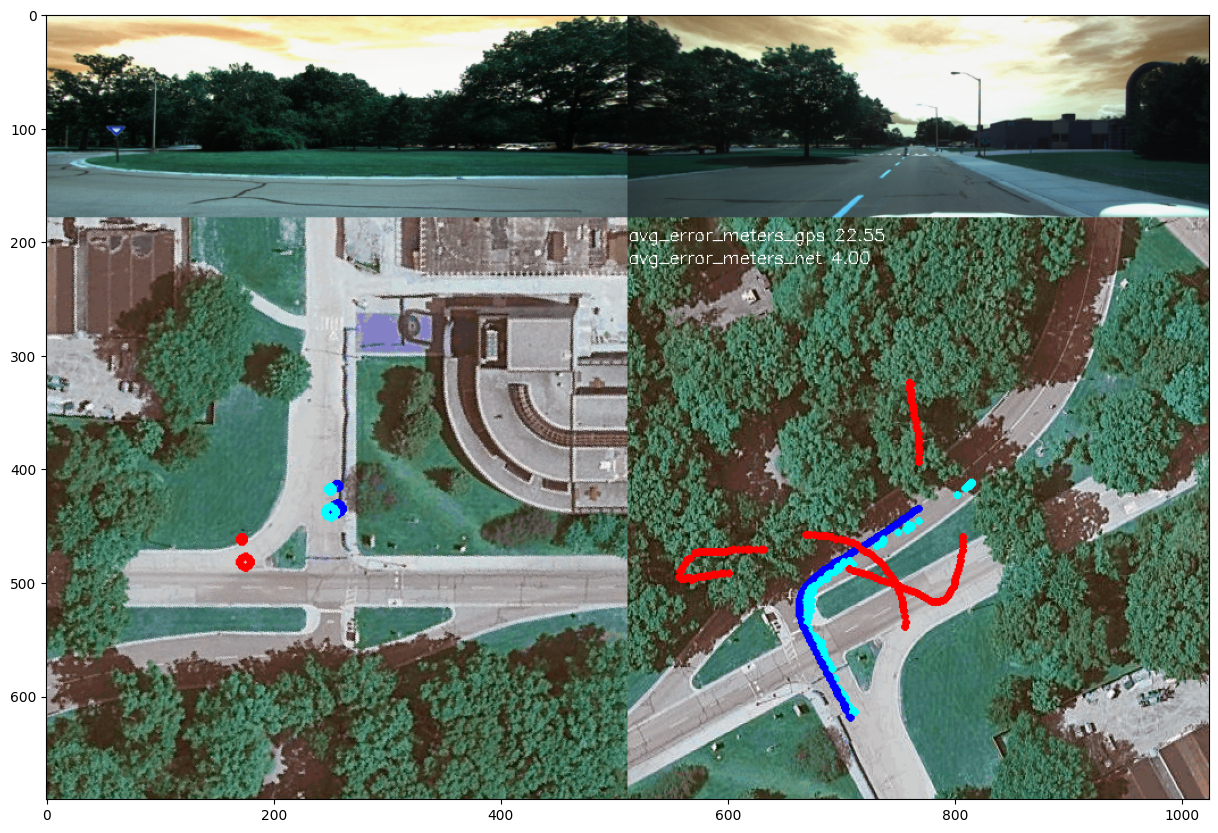

In [60]:
s = 0
from IPython.display import clear_output
from io import BytesIO
from PIL import Image
import cv2


s_lats = []; s_lons = []
g_lats = []; g_lons = []
gt_shift_u_meters = []; gt_shift_v_meters = []
pred_shift_u_meters = []; pred_shift_v_meters = []

yaws = []
for data in testloader:
    s+=1
    sat_img, grd_imgs, gt_shift_u, gt_shift_v, gt_heading, grd_names, sat_img_norot_notran, s_lat, s_lon, g_lat, g_lon, yaw = [[camera.to(device) if type(camera) == torch.Tensor else camera for camera in item] if type(item)== list else item.to(device) if type(item) == torch.Tensor else item for item in data]
    s_lats.append(s_lat); s_lons.append(s_lon)
    g_lats.append(g_lat); g_lons.append(g_lon)
    yaws.append(yaw)

    with torch.no_grad():
        pred_u, pred_v, pred_orien = net.CrossAttn_rot_corr(sat_img, grd_imgs, gt_shift_u, gt_shift_v, gt_heading, mode='test')
        pred_u_pixels = pred_u.cpu()/test_set.meters_per_pixel
        pred_v_pixels = pred_v.cpu()/test_set.meters_per_pixel


    gt_shift_u_pixels = gt_shift_u.cpu() * test_set.shift_range_meters_lon/ test_set.meters_per_pixel
    gt_shift_v_pixels = gt_shift_v.cpu() * test_set.shift_range_meters_lat/ test_set.meters_per_pixel
    
    gt_shift_u_meters.append(gt_shift_u.cpu() * test_set.shift_range_meters_lon)
    gt_shift_v_meters.append(gt_shift_v.cpu() * test_set.shift_range_meters_lat)
    pred_shift_u_meters.append(pred_u.cpu())
    pred_shift_v_meters.append(pred_v.cpu())


    # fig = plt.figure(figsize=(20, 20))
    # gs = gridspec.GridSpec(4, 2, wspace=0, hspace=0)
    # ax0 = fig.add_subplot(gs[0, 0:2])# This spans all columns in the first row
    # ax10 = fig.add_subplot(gs[1, 0])
    # ax11 = fig.add_subplot(gs[1, 1])

    sat_map_center = 512//2

    grd_imgs_plt = torch.cat((grd_imgs[1].cpu(), grd_imgs[0].cpu()), dim = -1).squeeze(0).permute([1,2,0])
    sat_img_norot_notran_plt = sat_img_norot_notran.cpu().squeeze(0).permute([1,2,0])
    # img2_plt = img2.squeeze(0).permute([1,2,0])
    # img3_plt = img3.squeeze(0).permute([1,2,0])
    sat_img_plt = sat_img.cpu().squeeze(0).permute([1,2,0])


    a = 20
    gt_theta =  -gt_heading.cpu() * test_set.rotation_range * np.pi/180
    gt_shift_u_a =  -np.sin(gt_theta) * a
    gt_shift_v_a =  -np.cos(gt_theta) * a

    pred_theta = - pred_orien.cpu() * test_set.rotation_range * np.pi/180 
    pred_shift_u_a =  -np.sin(pred_theta) * a
    pred_shift_v_a =  -np.cos(pred_theta) * a

    print(gt_shift_u_pixels, gt_shift_v_pixels, gt_heading)
    print(pred_u_pixels, pred_v_pixels, pred_orien)#, pred_u_pixels, pred_v_pixels)
    
    

    sat_img_norot_notran_cv2 = cv2.cvtColor(sat_img_norot_notran_plt.numpy().copy(), cv2.COLOR_BGR2RGB)
    cv2.circle(sat_img_norot_notran_cv2, (sat_map_center, sat_map_center), radius=5, color=(0, 0, 255), thickness=5)
    cv2.circle(sat_img_norot_notran_cv2, (sat_map_center, sat_map_center-a), radius=3, color=(0, 0, 255), thickness=3)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels), int(sat_map_center+gt_shift_v_pixels)), radius=5, color=(255, 0, 0), thickness=5)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels+gt_shift_u_a), int(sat_map_center+gt_shift_v_pixels+gt_shift_v_a)), radius=3, color=(255, 0, 0), thickness=3)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels-pred_u_pixels), int(sat_map_center+gt_shift_v_pixels-pred_v_pixels)), radius=5, color=(0, 255, 255), thickness=5)
    cv2.circle(sat_img_norot_notran_cv2, (int(sat_map_center+gt_shift_u_pixels-pred_u_pixels+gt_shift_u_a-pred_shift_u_a), int(sat_map_center+gt_shift_v_pixels-pred_v_pixels+pred_shift_v_a)), radius=3, color=(0, 255, 255), thickness=3)

    grd_imgs_cv2 = cv2.cvtColor(grd_imgs_plt.numpy().copy(), cv2.COLOR_BGR2RGB)
    grd_imgs_cv2 = cv2.resize(grd_imgs_cv2, (grd_imgs_cv2.shape[1]//2, int(grd_imgs_cv2.shape[0]*0.7),))

    sat_img_norot_notran_cv2 = cv2.resize(sat_img_norot_notran_cv2, (grd_imgs_cv2.shape[1]//2,)*2)
    if s==1: zeros_right = sat_map#np.zeros_like(sat_img_norot_notran_cv2)[:,:sat_img_norot_notran_cv2.shape[1],:] 


    traj_1, traj_2, traj_3, gps_shift, net_shift = calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws)
    zeros_right = tranjectories2image(traj_1, traj_2, traj_3, zeros_right)

    avg_error_meters_gps = gps_shift[0] ** 2 + gps_shift[1] **2; avg_error_meters_gps = avg_error_meters_gps.mean().item() ** 0.5
    avg_error_meters_net = net_shift[0] ** 2 + net_shift[1] **2; avg_error_meters_net = avg_error_meters_net.mean().item() ** 0.5

    zeros_right_text = cv2.putText(zeros_right.copy(), text = f'avg_error_meters_gps {avg_error_meters_gps:.2f}', org=(0, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255))
    cv2.putText(zeros_right_text, text = f'avg_error_meters_net {avg_error_meters_net:.2f}', org=(0, 40), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(255,255,255))

    sat_img_norot_notran_cv2 = np.concatenate((sat_img_norot_notran_cv2,zeros_right_text), axis=1)




    # corr = get_corr_map(net, sat_img_norot_notran)
    # corr = cv2.resize(corr, (sat_img_norot_notran_cv2.shape[1], sat_img_norot_notran_cv2.shape[0]))
    # sat_img_norot_notran_cv2 = np.clip(sat_img_norot_notran_cv2*0.5  + corr , 0, 1)

    # map_idx = 2
    # heat_map  =  (net.corr_maps[map_idx] - net.corr_maps[map_idx].min())/(net.corr_maps[map_idx].max()- net.corr_maps[map_idx].min())
    # heat_map = 1 - heat_map
    # heat_map = torch.cat((torch.zeros_like(heat_map), torch.zeros_like(heat_map), heat_map), dim = 0).permute([1,2,0])
    # heat_map = heat_map.cpu().numpy().copy()
    # heat_map = cv2.resize(heat_map, (sat_img_norot_notran_cv2.shape[1], sat_img_norot_notran_cv2.shape[0]))

    
    # rotate and translate corr map
    # angle = float(-pred_orien*test_set.rotation_range)  ;center = (heat_map.shape[1] // 2, heat_map.shape[0] // 2); scale = 1.0 ;transform_matrix = cv2.getRotationMatrix2D(center, angle, scale)
    # transform_matrix[0, 2] +=gt_shift_u_pixels * 2#sat_img_norot_notran_cv2.shape[1] * 0.5 / net.corr_maps[map_idx].shape[2]
    # transform_matrix[1, 2] +=gt_shift_v_pixels * 2#sat_img_norot_notran_cv2.shape[0] * 0.5 / net.corr_maps[map_idx].shape[1]
    # heat_map = cv2.warpAffine(heat_map, transform_matrix, (heat_map.shape[1], heat_map.shape[0]))
    # heat_map = heat_map **2
    # sat_img_norot_notran_cv2 = sat_img_norot_notran_cv2 * 0.5 + heat_map * 0.5

    # max_index = np.argmax(heat_map_new[:,:, -1])
    # pred_u = max_index % heat_map.shape[1]  # / self.args.shift_range_lon
    # pred_v = max_index // heat_map.shape[1] 
    # cv2.circle(heat_map_new, (pred_u, pred_v), radius=2, color=(255, 0, 0), thickness=20)

    img = np.concatenate((grd_imgs_cv2, sat_img_norot_notran_cv2), axis=0)


    cv2.imshow('img', img)
    cv2.waitKey(1) 

    # ax0.imshow(grd_imgs_plt)
    # ax10.imshow(sat_img_norot_notran_plt)
    # ax10.scatter((sat_map_center), (sat_map_center), color = 'red', s=50)
    # ax10.scatter((sat_map_center), (sat_map_center-a), color = 'red', s=20)

    # ax10.scatter((sat_map_center+gt_shift_u_pixels), (sat_map_center+gt_shift_v_pixels), color = 'blue', s=50)
    # ax10.scatter((sat_map_center+gt_shift_u_pixels+gt_shift_u_a), (sat_map_center+gt_shift_v_pixels+gt_shift_v_a), color = 'blue', s=20)

    # ax10.scatter((sat_map_center+gt_shift_u_pixels-pred_u_pixels), (sat_map_center+gt_shift_v_pixels-pred_v_pixels), color = 'yellow', s=50)
    # ax10.scatter((sat_map_center+gt_shift_u_pixels-pred_u_pixels+gt_shift_u_a-pred_shift_u_a), (sat_map_center+gt_shift_v_pixels-pred_v_pixels+pred_shift_v_a), color = 'yellow', s=20)

    # ax11.imshow(sat_img_plt)
    # ax11.scatter((sat_map_center), (sat_map_center), color = 'blue', s=50)
    # ax11.scatter((sat_map_center), (sat_map_center-a), color = 'blue', s=20)

    # ax11.scatter((sat_map_center-gt_shift_u_pixels), (sat_map_center-gt_shift_v_pixels), color = 'red', s=50)
    # ax11.scatter((sat_map_center-gt_shift_u_pixels-gt_shift_u_a), (sat_map_center-gt_shift_v_pixels+gt_shift_v_a), color = 'red', s=20)

    # ax11.scatter((sat_map_center-pred_u_pixels), (sat_map_center-pred_v_pixels), color = 'yellow', s=50)
    # ax11.scatter((sat_map_center-pred_u_pixels-pred_shift_u_a), (sat_map_center-pred_v_pixels+pred_shift_v_a), color = 'yellow', s=20)


    # plt.show()
    if s>16*10:break
# closing all open windows 
cv2.destroyAllWindows() 

plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()

In [171]:
avg_error_meters_net = traj_3[0] ** 2 + traj_3[1] **2; avg_error_meters_net = avg_error_meters_net.mean().item() ** 0.5
avg_error_meters_gps

88.23862226126164

C:\Users\dimitris\AppData\Local\Temp\ipykernel_28652\1701141413.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())
C:\Users\dimitris\AppData\Local\Temp\ipykernel_28652\1701141413.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yaws = torch.tensor(yaws)
C:\Users\dimitris\AppData\Local\Temp\ipykernel_28652\2179544619.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y, x = utils.gps2met

[]

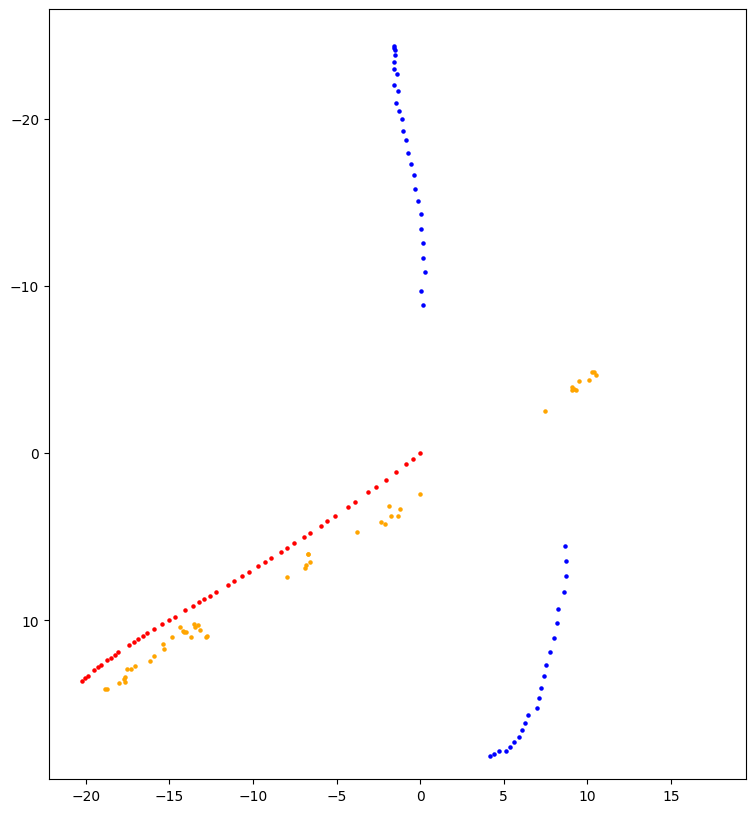

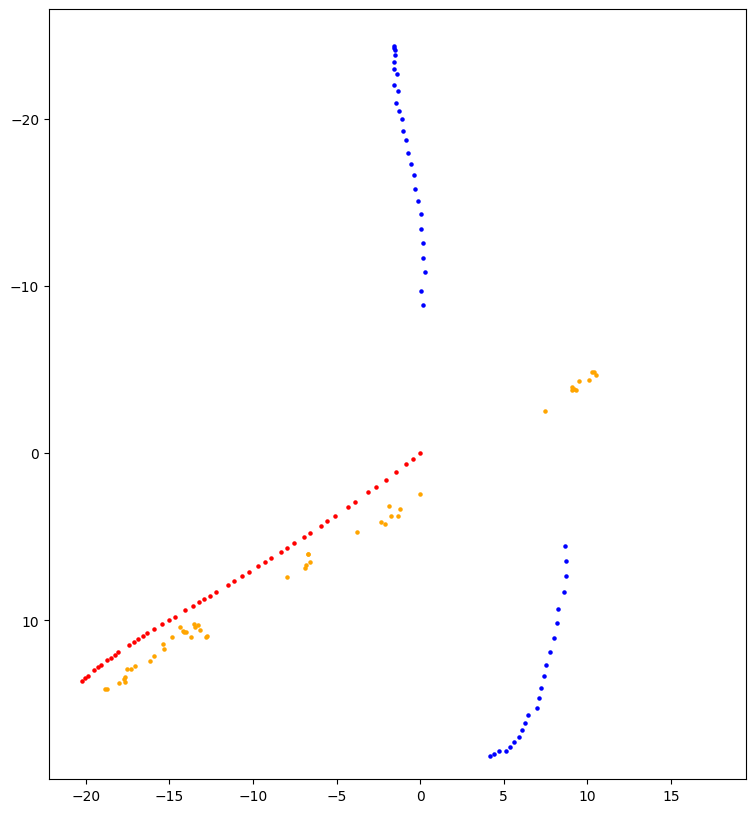

In [135]:

y, x = utils.gps2meters_torch(torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu(), torch.tensor(g_lats[0]).cpu(), torch.tensor(g_lons[0]).cpu())
x = -x ;y = -y
# y = -y
# latlon = torch.stack((torch.tensor(g_lats).cpu(), torch.tensor(g_lons).cpu()), dim =1).unsqueeze(0)

# d = utils.gps2shiftmeters(latlon)
# x = d[0, : ,0]
# y = d[0, : ,1]

xy_shift_gt = torch.stack((torch.tensor(gt_shift_v_meters), torch.tensor(gt_shift_u_meters)))
xy_shift_pred = torch.stack((torch.tensor(pred_shift_v_meters), torch.tensor(pred_shift_u_meters)))
xy_error = xy_shift_gt - xy_shift_pred

yaws = torch.tensor(yaws) 
yaws_rad = (yaws * torch.pi / 180.0) 

row_1 = torch.stack([torch.cos(yaws_rad), torch.sin(yaws_rad)], dim =1).unsqueeze(1)
row_2 = torch.stack([-torch.sin(yaws_rad), torch.cos(yaws_rad)], dim =1).unsqueeze(1)
rot_mat = torch.concat([row_1,row_2], dim=1)

xy_shift_gt_new = rot_mat @ xy_shift_gt.T.unsqueeze(-1)
xy_shift_gt_new = xy_shift_gt_new.squeeze(-1).T
xy_error_new = rot_mat @ xy_error.T.unsqueeze(-1)
xy_error_new = xy_error_new.squeeze(-1).T



plt.figure(figsize=(10,10))
plt.imshow(torch.ones(20,20,3))
plt.scatter(y, x, s= 5, color='red')
plt.scatter(y+xy_shift_gt_new[1], x+xy_shift_gt_new[0], s= 5, color='blue')
plt.scatter(y+xy_error_new[1], x+xy_error_new[0], s= 5, color='orange')
plt.plot()

traj_1, traj_2, traj_3 = calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws)


plt.figure(figsize=(10,10))
plt.imshow(torch.ones(20,20,3))
plt.scatter(traj_1[1], traj_1[0], s= 5, color='red')
plt.scatter(traj_2[1], traj_2[0], s= 5, color='blue')
plt.scatter(traj_3[1], traj_3[0], s= 5, color='orange')

plt.plot()

# image = np.ones((512,512, 3), dtype=np.float32)
# traj_1, traj_2, traj_3 = calculate_tranjectories(g_lats, g_lons, gt_shift_v_meters, gt_shift_u_meters, pred_shift_v_meters, pred_shift_u_meters, yaws)

# image[traj_1[0], traj_1[1], :] = 0

# plt.figure(figsize=(10,10))
# plt.imshow(image)
# plt.plot()

In [174]:
xy_shift = torch.stack((torch.tensor(gt_shift_v_meters), torch.tensor(gt_shift_u_meters)))
yaws_new = torch.tensor(yaws).cpu()
yaws_rad = yaws_new * torch.pi / 180.0

row_1 = torch.stack([torch.cos(yaws_rad), torch.sin(yaws_rad)], dim =1).unsqueeze(1)
row_2 = torch.stack([-torch.sin(yaws_rad), torch.cos(yaws_rad)], dim =1).unsqueeze(1)
rot_mat = torch.concat([row_1,row_2], dim=1)

xy_shift_new = rot_mat @ xy_shift.T.unsqueeze(-1)
xy_shift_new = xy_shift_new.squeeze(-1).T

print(xy_shift[0])
print(xy_shift[1])

print(xy_shift_new[0])
print(xy_shift_new[1])

print(yaws_new)

print(rot_mat[0])
print(torch.sin(yaws_rad[0]))
# rot_mat = torch.tensor([
#         [torch.cos(yaws), torch.sin(yaws)],
#         [-torch.sin(yaws), torch.cos(yaws)]
#     ])

tensor([14.0000, 14.3767, 14.7520, 15.1243, 15.4921, 15.8541, 16.2087, 16.5547,
        16.8905, 17.2150, 17.5267, 17.8245, 18.1073, 18.3738, 18.6231, 18.8541,
        19.0660, 19.2578, 19.4290, 19.5787, 19.7063, 19.8115, 19.8937, 19.9527,
        19.9882, 20.0000, 19.9882])
tensor([20.0000, 19.9763, 19.9054, 19.7874, 19.6230, 19.4127, 19.1573, 18.8579,
        18.5157, 18.1319, 17.7082, 17.2462, 16.7476, 16.2146, 15.6491, 15.0534,
        14.4299, 13.7810, 13.1094, 12.4175, 11.7082, 10.9843, 10.2486,  9.5040,
         8.7535,  8.0000, -8.7535])
tensor([-24.3613, -24.5863, -24.7670, -24.9054, -24.9961, -25.0392, -25.0374,
        -24.9806, -24.8879, -24.7325, -24.5474, -24.3188, -24.0397, -23.7282,
        -23.3594, -22.9704, -22.5418, -22.0644, -21.5789, -21.0575, -20.4937,
        -19.9158, -19.3122, -18.6907, -18.0351, -17.3852,  -3.1432])
tensor([-1.5893, -1.1225, -0.6626, -0.0839,  0.5149,  1.1159,  1.6900,  2.3764,
         2.9518,  3.6641,  4.2651,  4.8724,  5.5181,  6.1221,  6.

In [56]:
s_lats[-1].item(), s_lons[-1].item(), len(g_lats)

(42.321191125075515, -83.23366831335787, 201)

In [25]:
p = torch.stack((x,y))
dp = p[:, 1:] - p[:, 0:-1]
tan_th = dp[1]/dp[0]
th = torch.arctan(tan_th) 

th

tensor([-0.9023, -0.9086, -0.9170, -0.9244, -0.9343, -0.9408, -0.9473, -0.9554,
        -0.9640, -0.9670, -0.9721, -0.9799, -0.9868, -0.9896, -0.9955, -1.0016,
        -1.0065, -1.0113, -1.0152, -1.0180, -1.0202, -1.0234, -1.0263, -1.0288,
        -1.0321, -1.0325, -1.0339, -1.0276, -1.0299, -1.0341, -1.0320, -1.0245,
        -1.0196, -1.0223, -1.0195, -1.0135, -1.0077, -0.9972, -0.9686, -0.9552,
        -0.9455, -0.9331, -0.9184, -0.9057, -0.8847, -0.8606, -0.8412, -0.8305,
        -0.8107, -0.7865, -0.7821, -0.7630, -0.7484, -0.7135, -0.6685, -0.6599,
        -0.6318, -0.5996, -0.5767, -0.5527, -0.5332, -0.5110, -0.4876, -0.4597,
        -0.4382, -0.4172, -0.3976, -0.3828, -0.3716, -0.3401, -0.3102, -0.2823,
        -0.2683, -0.2582, -0.2347, -0.2152, -0.2077, -0.1979, -0.1848, -0.1575,
        -0.1462, -0.1332, -0.1237, -0.1059, -0.0824, -0.0662, -0.0555, -0.0470,
        -0.0394, -0.0311, -0.0154,  0.0078,  0.0241,  0.0366,  0.0497,  0.0833,
         0.1121,  0.1254,  0.1550,  0.18

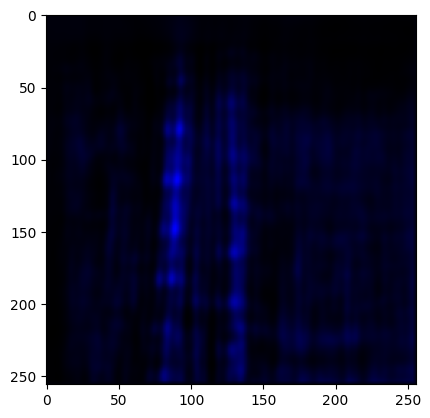

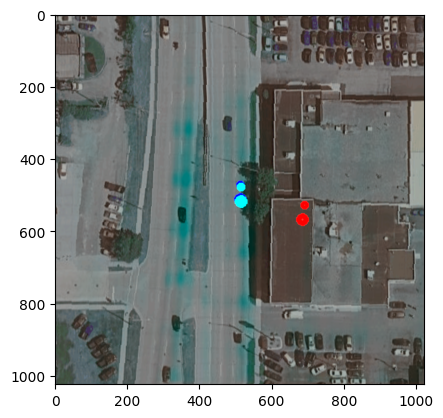

In [ ]:
corr = get_corr_map(net, sat_img_norot_notran)
plt.imshow(corr)
plt.show()
plt.imshow(sat_img_norot_notran_cv2)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

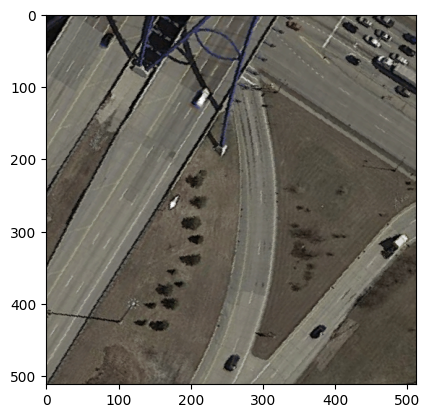

In [ ]:

idx = 2
img = net.corr_maps[idx].squeeze(0)

max_index = torch.argmin(img.reshape(1, -1), dim=1)
corr_W = img.shape[1]
corr_H = img.shape[0]

pred_uu = (max_index % corr_W - corr_W / 2) * net.meters_per_pixel[idx] # / self.args.shift_range_lon
pred_vv = (max_index // corr_W - corr_H / 2) * net.meters_per_pixel[idx]
scatter_u = (max_index % corr_W)
scatter_v = (max_index // corr_W)


cos = torch.cos(gt_heading * net.args.rotation_range / 180 * np.pi)
sin = torch.sin(gt_heading * net.args.rotation_range / 180 * np.pi)

pred_u1 = - pred_uu * cos + pred_vv * sin
pred_v1 = - pred_uu * sin - pred_vv * cos

img = img.cpu().numpy().copy()

plt.imshow(sat_img_plt)
plt.scatter(scatter_u, scatter_v,  color='red')
plt.show()
plt.imshow(img)

print(pred_u, pred_v)
print(pred_u1, pred_v1)
# max_index = np.argmax(heat_map_new[:,:, -1])
# pred_u = max_index % heat_map_new.shape[1]  # / self.args.shift_range_lon
# pred_v = max_index // heat_map_new.shape[1] 

# pred_u, pred_v

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

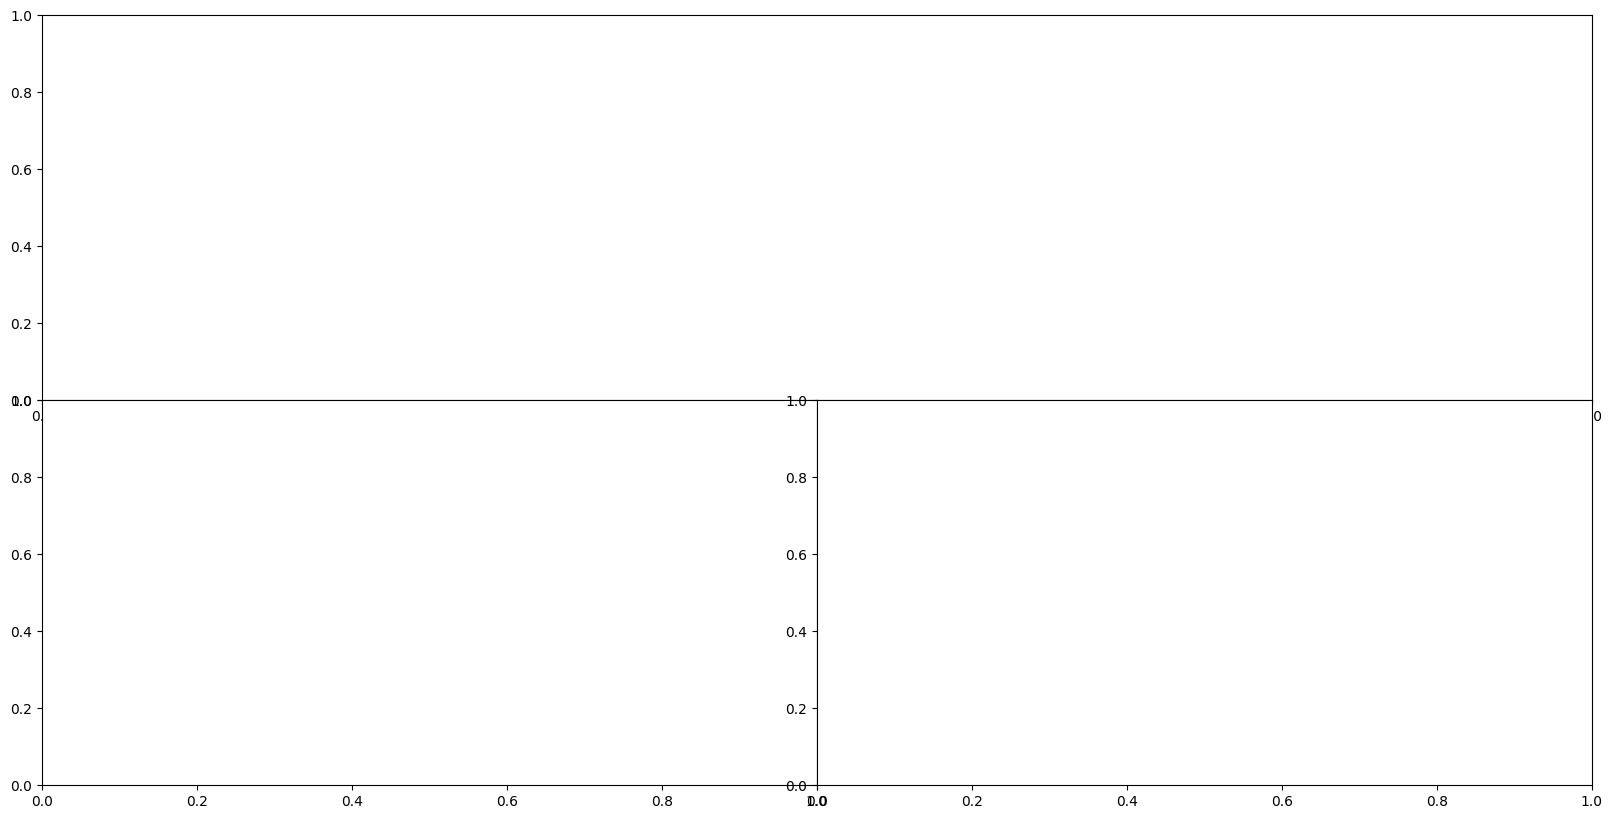

In [ ]:
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4, 2, wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0:2])# This spans all columns in the first row
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
# ax2 = fig.add_subplot(gs[2, 0:2])
# ax3 = fig.add_subplot(gs[3, 0:2])

a = 20
gt_theta =  -gt_heading * test_set.rotation_range * np.pi/180
gt_shift_u_a =  -np.sin(gt_theta) * a
gt_shift_v_a =  -np.cos(gt_theta) * a

pred_theta = - pred_orien * test_set.rotation_range * np.pi/180 
pred_shift_u_a =  -np.sin(pred_theta) * a
pred_shift_v_a =  -np.cos(pred_theta) * a

print(gt_shift_u_pixels, gt_shift_v_pixels, gt_heading, pred_u_pixels, pred_v_pixels, pred_orien)#, pred_u_pixels, pred_v_pixels)
ax0.imshow(grd_imgs_plt)
# ax1.imshow(img2_plt)
# ax2.imshow(img3_plt)

ax10.imshow(sat_img_norot_notran)
ax10.scatter((sat_map_center), (sat_map_center), color = 'red', s=50)
ax10.scatter((sat_map_center), (sat_map_center-a), color = 'red', s=20)

ax10.scatter((sat_map_center+gt_shift_u_pixels), (sat_map_center+gt_shift_v_pixels), color = 'blue', s=50)
ax10.scatter((sat_map_center+gt_shift_u_pixels+gt_shift_u_a), (sat_map_center+gt_shift_v_pixels+gt_shift_v_a), color = 'blue', s=20)

ax10.scatter((sat_map_center+gt_shift_u_pixels-pred_u_pixels), (sat_map_center+gt_shift_v_pixels-pred_v_pixels), color = 'yellow', s=50)
ax10.scatter((sat_map_center+gt_shift_u_pixels-pred_u_pixels+gt_shift_u_a-pred_shift_u_a), (sat_map_center+gt_shift_v_pixels-pred_v_pixels+pred_shift_v_a), color = 'yellow', s=20)


ax11.imshow(sat_img_plt)
ax11.scatter((sat_map_center), (sat_map_center), color = 'blue', s=50)
# ax11.scatter((sat_map_center), (sat_map_center-a), color = 'blue', s=20)

ax11.scatter((sat_map_center-gt_shift_u_pixels), (sat_map_center-gt_shift_v_pixels), color = 'red', s=50)
# ax11.scatter((sat_map_center-gt_shift_u_pixels-gt_shift_u_a), (sat_map_center-gt_shift_v_pixels+gt_shift_v_a), color = 'red', s=20)

ax11.scatter((sat_map_center-pred_u_pixels), (sat_map_center-pred_v_pixels), color = 'yellow', s=50)
# ax11.scatter((sat_map_center-pred_u_pixels+gt_shift_u_a), (sat_map_center-pre_v_pixels+gt_shift_v_a), color = 'yellow', s=20)

plt.show()

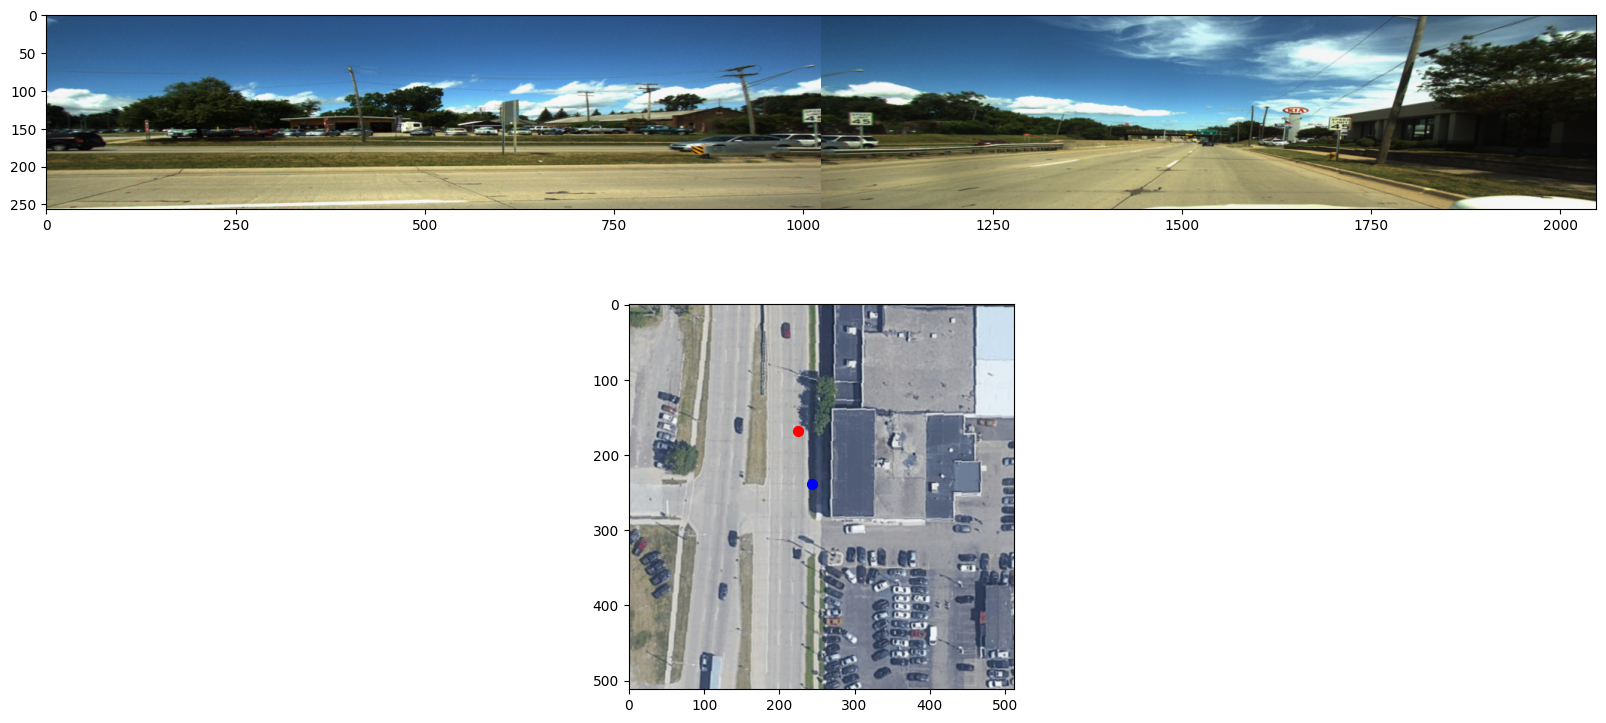

In [ ]:
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4, 2, wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0:2])# This spans all columns in the first row
ax1 = fig.add_subplot(gs[1, 0:2])


sat_map_center = 512/2

grd_imgs_plt = torch.cat((grd_imgs[1], grd_imgs[0]), dim = -1).squeeze(0).permute([1,2,0])
sat_img_plt = sat_img.squeeze(0).permute([1,2,0])

ax0.imshow(grd_imgs_plt)
ax1.imshow(sat_img_plt)
ax1.scatter((sat_map_center-gt_shift_u_pixels), (sat_map_center-gt_shift_v_pixels), color = 'red', s=50)
ax1.scatter((sat_map_center-pred_u_pixels), (sat_map_center-pre_v_pixels), color = 'blue', s=50)
